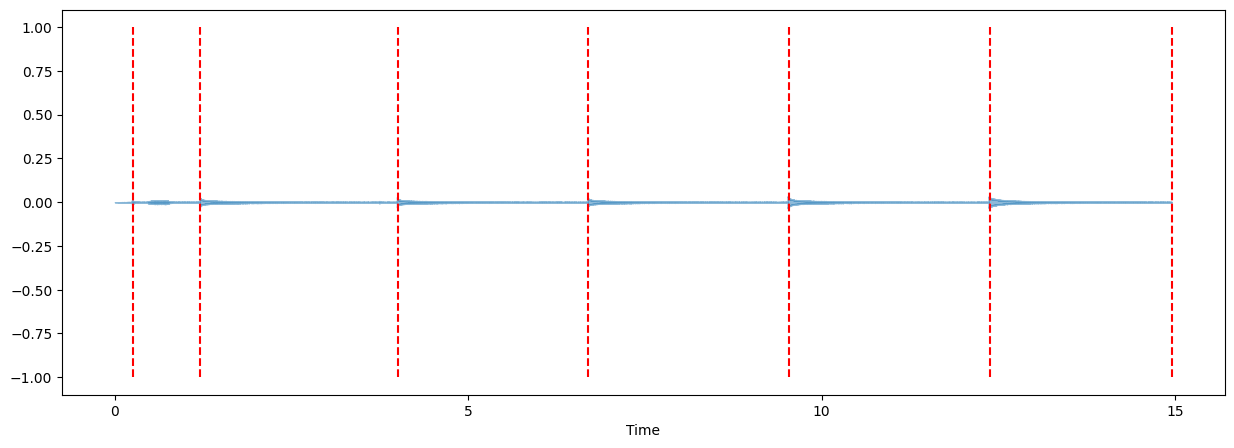

In [12]:
import librosa
import numpy as np
import soundfile as sf

# Načtení WAV souboru
audio_path = "output.wav"
y, sr = librosa.load(audio_path, sr=None)

# Detekce onsetů (začátků tónů) – OPRAVENÉ PARAMETRY
onsets = librosa.onset.onset_detect(
    y=y, 
    sr=sr, 
    units='time',
    hop_length=512,
    # Následující parametry se předávají do peak_pick, správné názvy jsou:
    pre_max=3,    # počet vzorků před maximem pro detekci
    post_max=3,   # počet vzorků po maximu
    pre_avg=3,    # průměr předcházejících vzorků
    post_avg=3,   # průměr následujících vzorků
    delta=0.3,    # minimální rozdíl mezi vrcholy
    wait=0       # minimální vzdálenost mezi tóny (v počtu vzorků)
)

# Zbytek kódu zůstává stejný...
onsets = np.append(onsets, len(y)/sr)

for i in range(len(onsets)-1):
    start_sample = int(onsets[i] * sr)
    end_sample = int(onsets[i+1] * sr)
    segment = y[start_sample:end_sample]
    sf.write(f"ton_{i+1}.wav", segment, sr)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.vlines(onsets, -1, 1, color='r', linestyle='--')
plt.show()

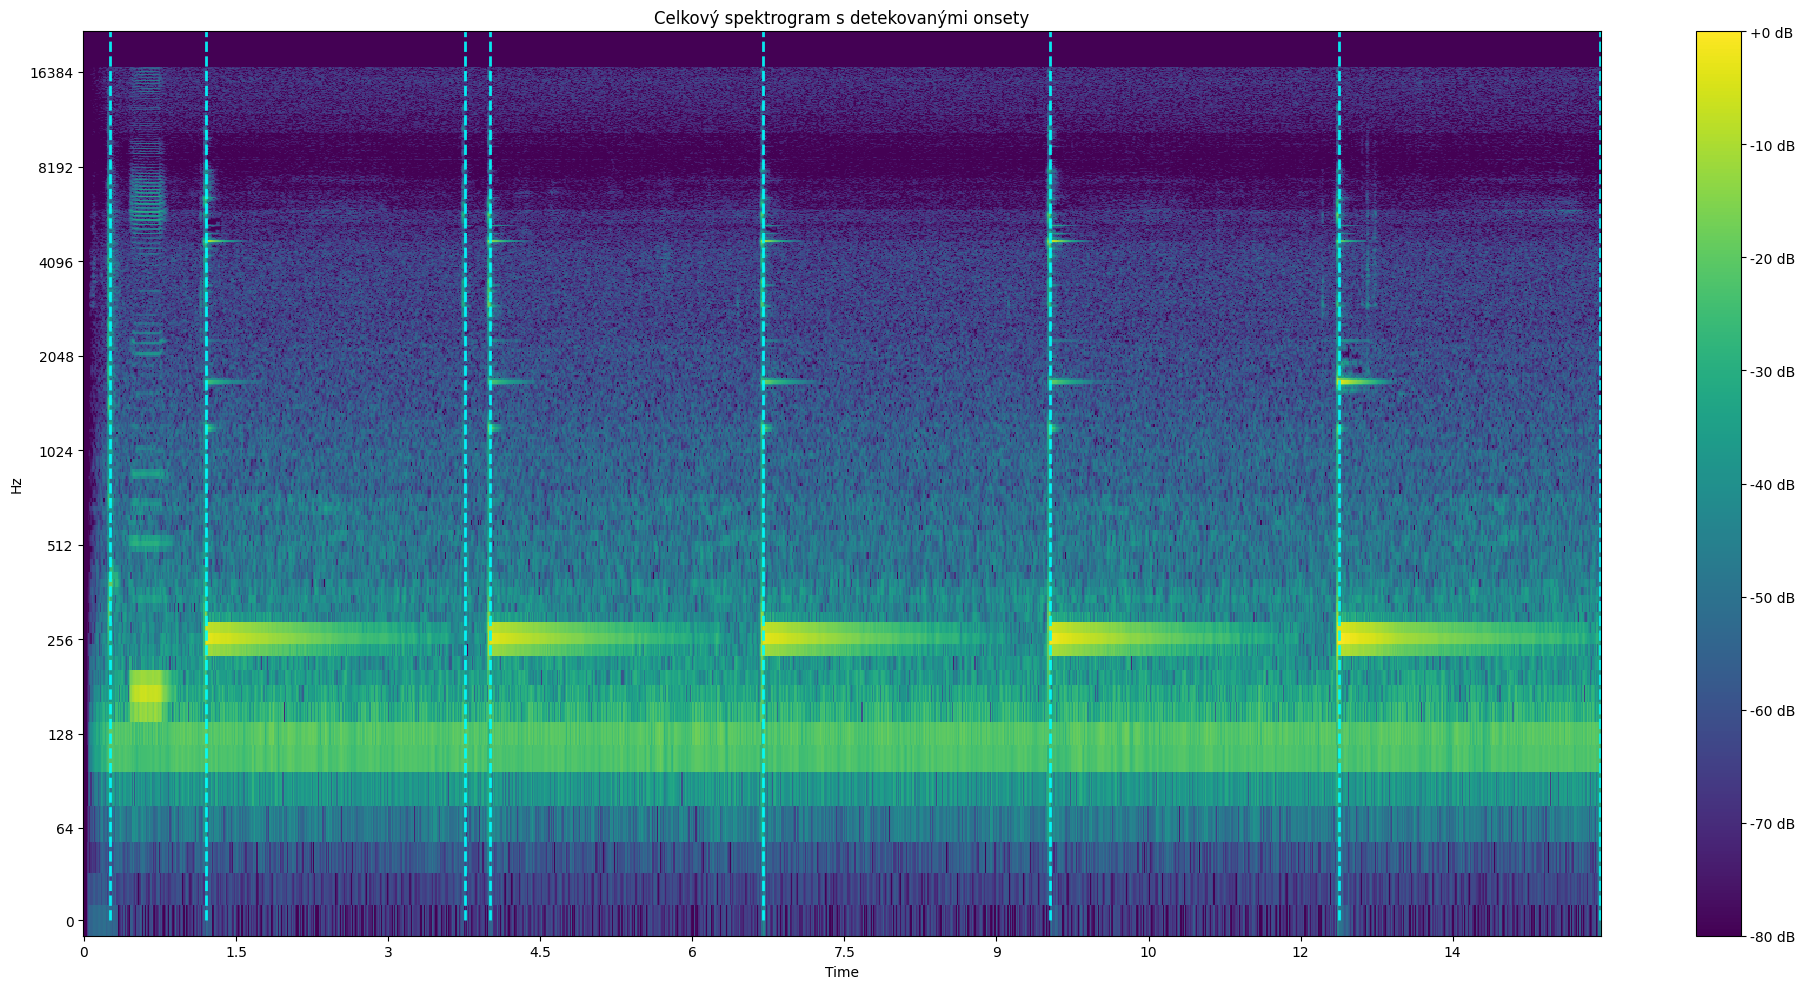

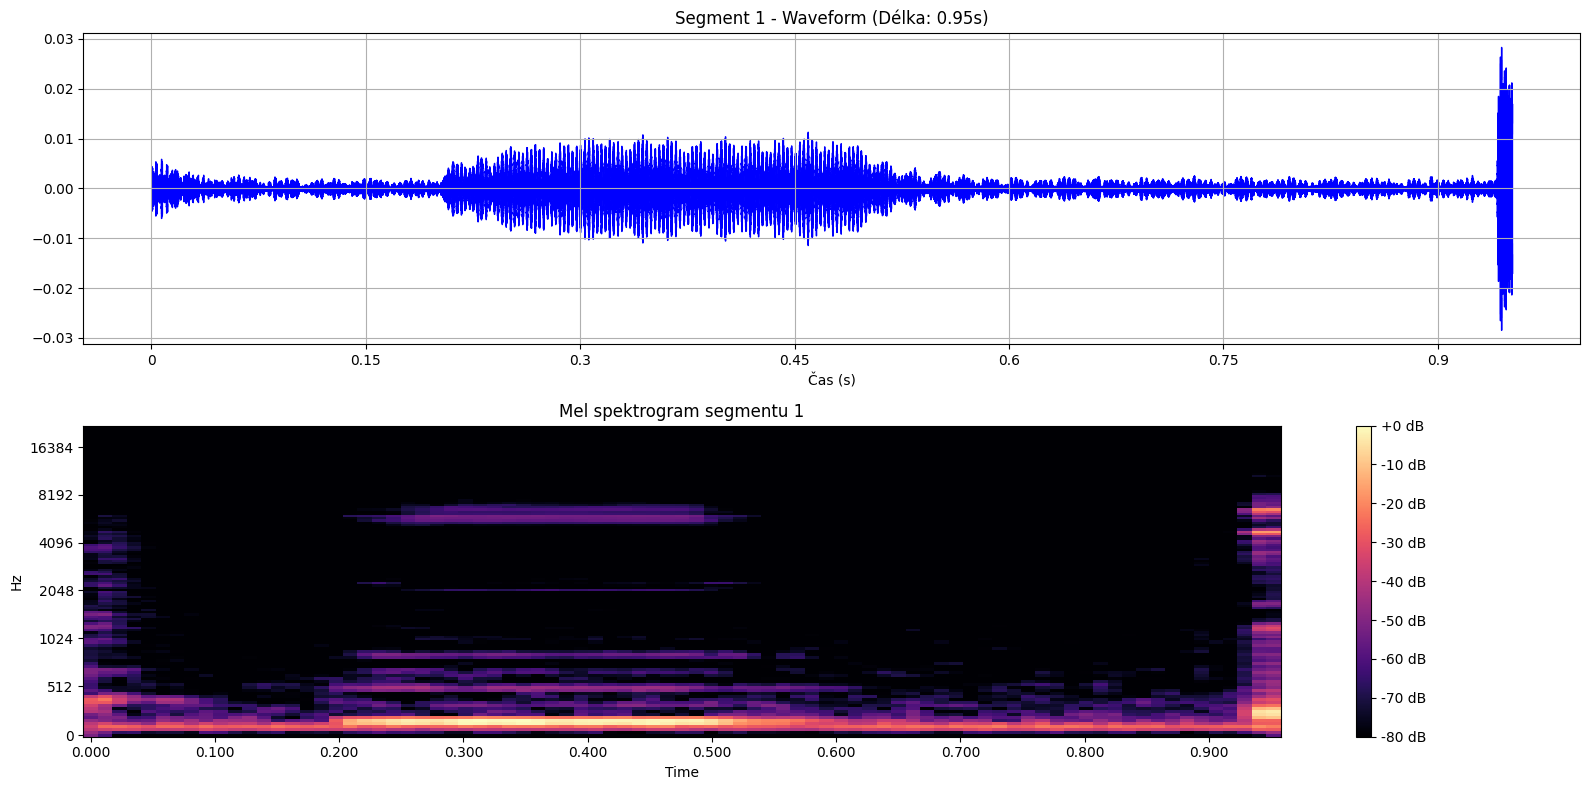

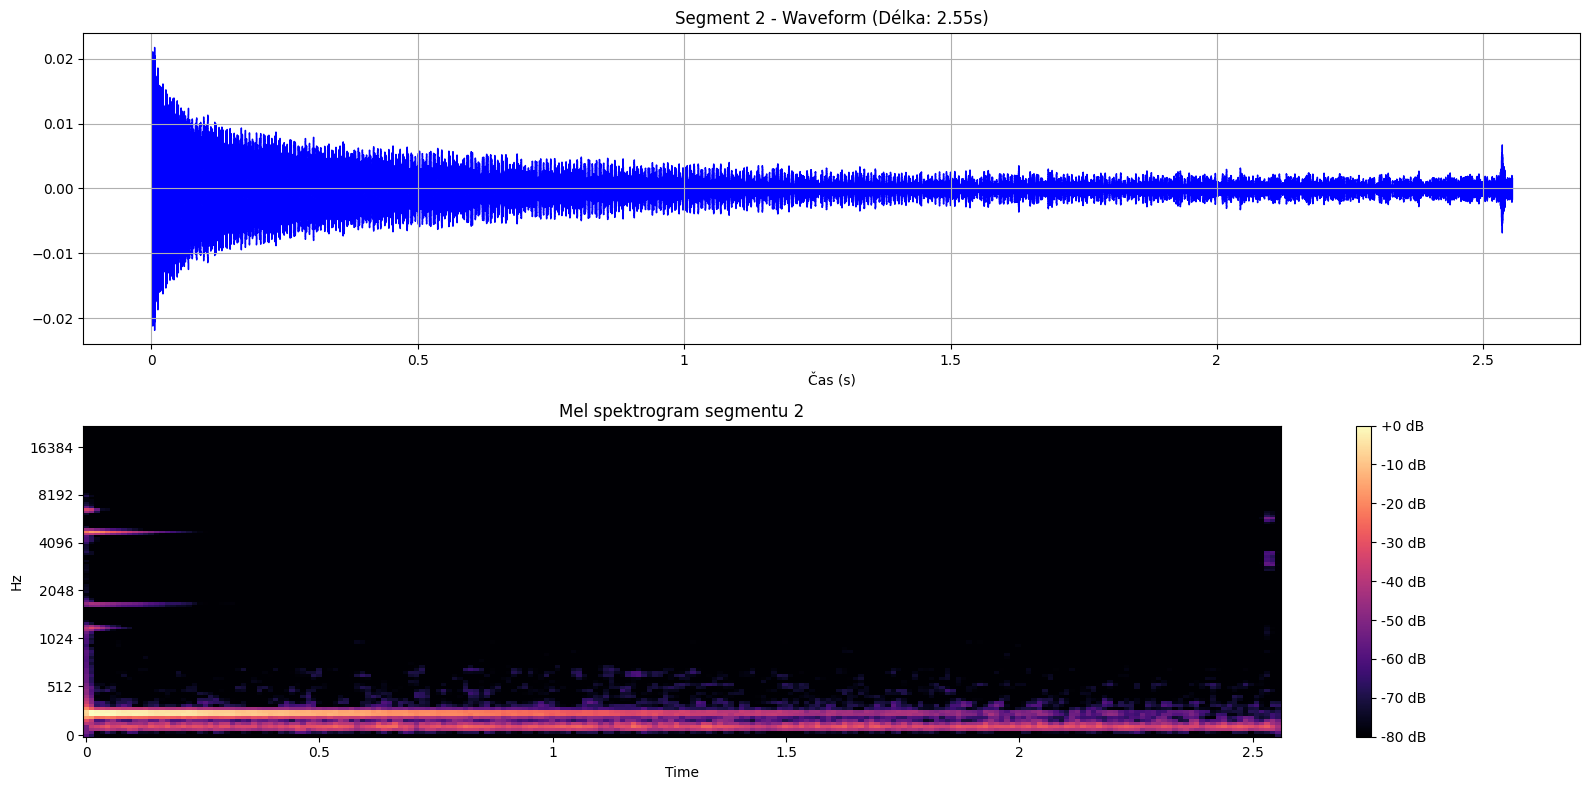

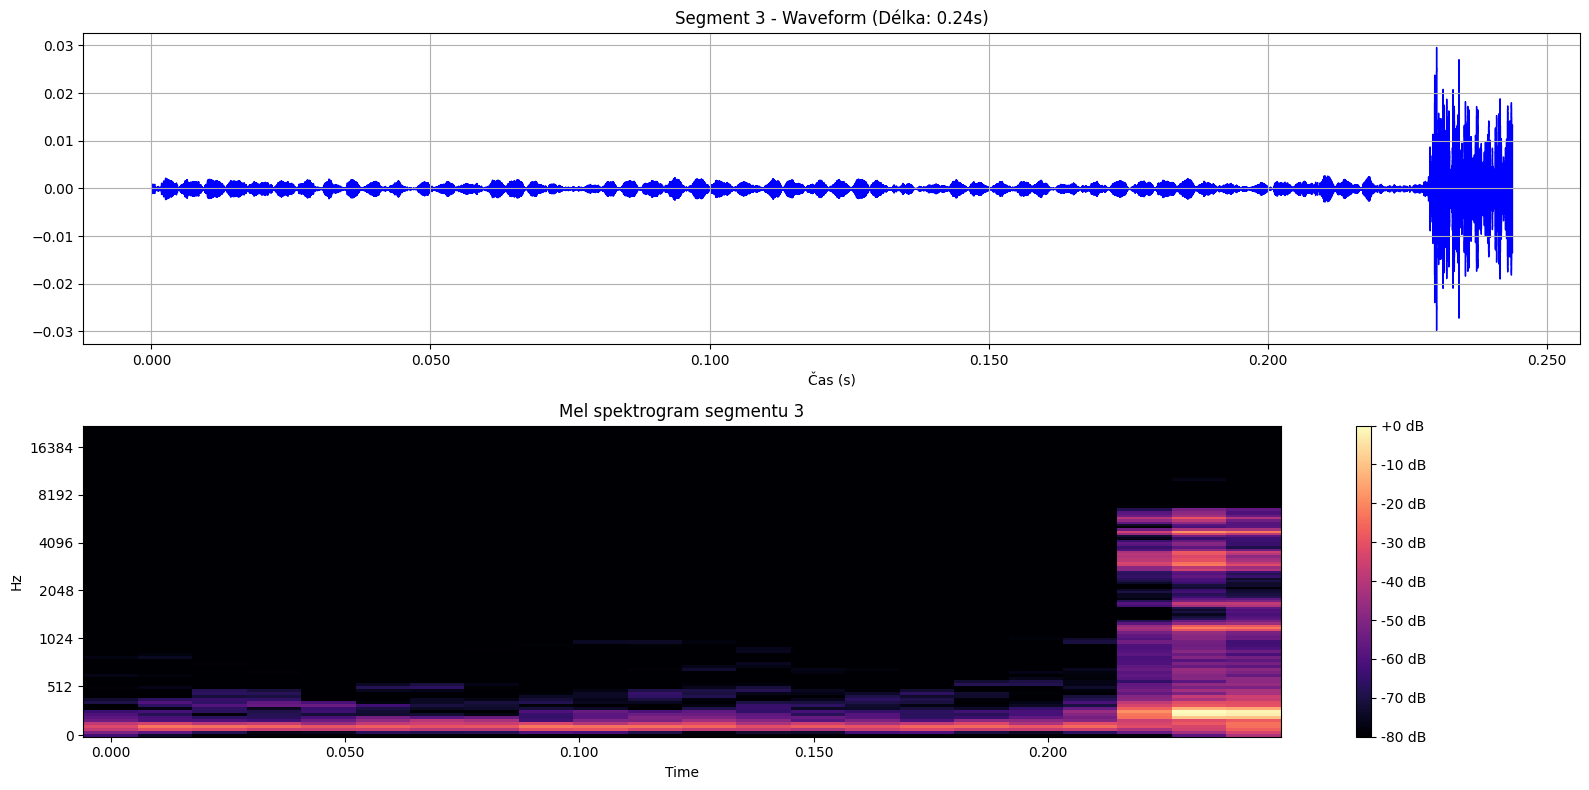

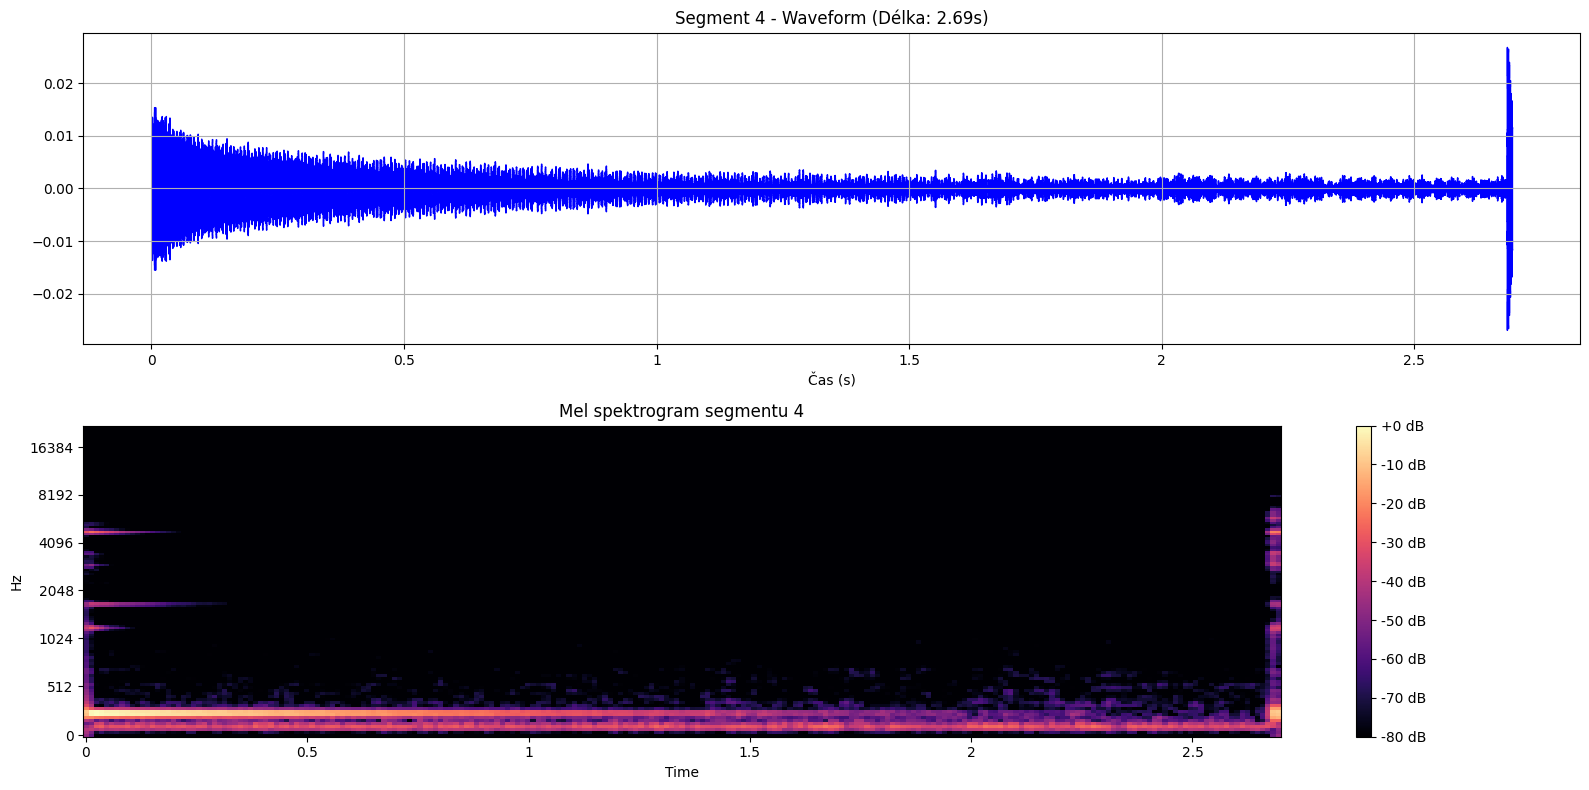

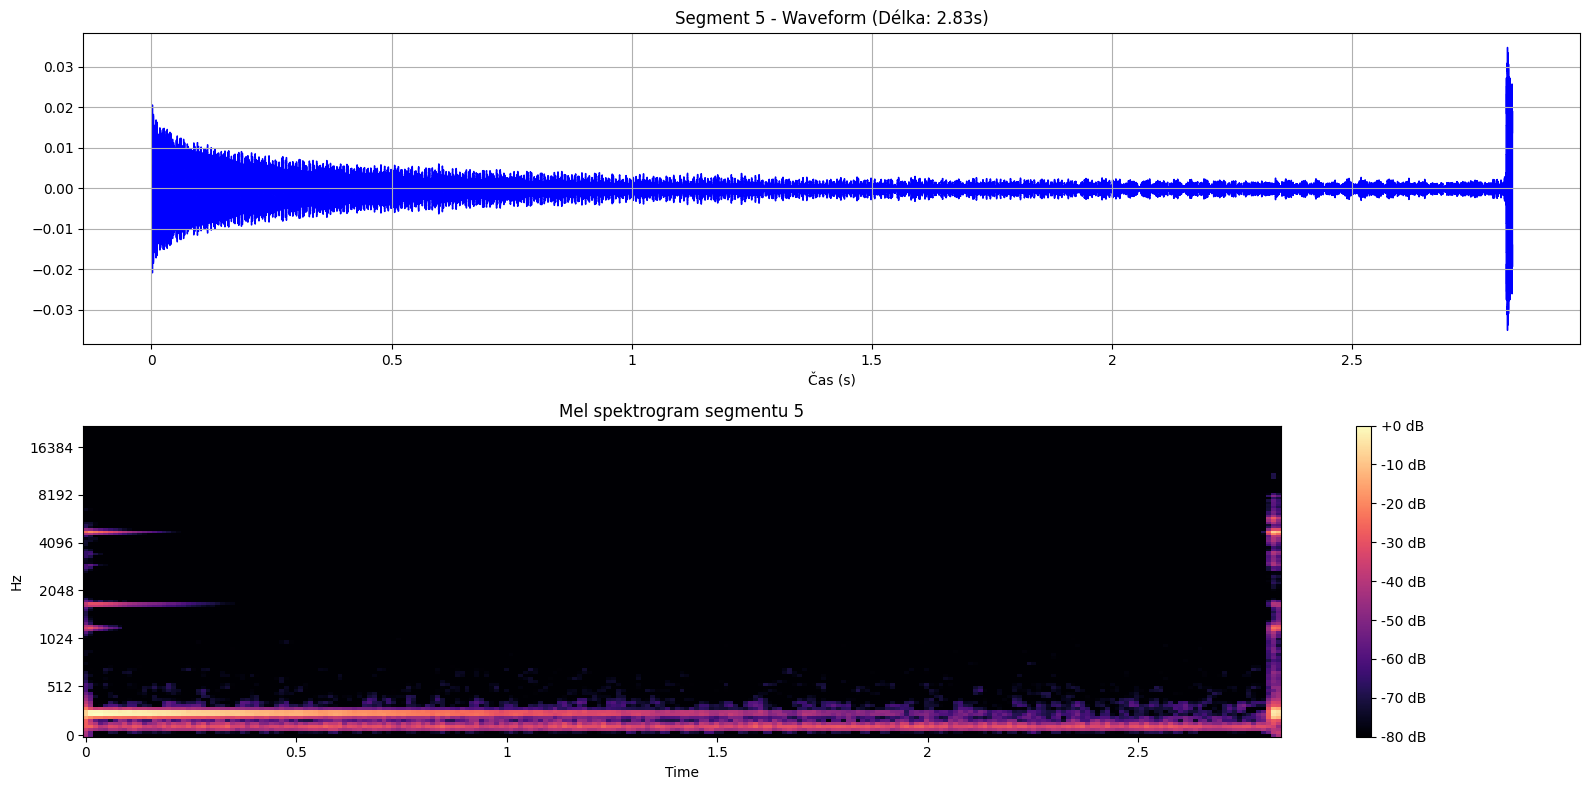

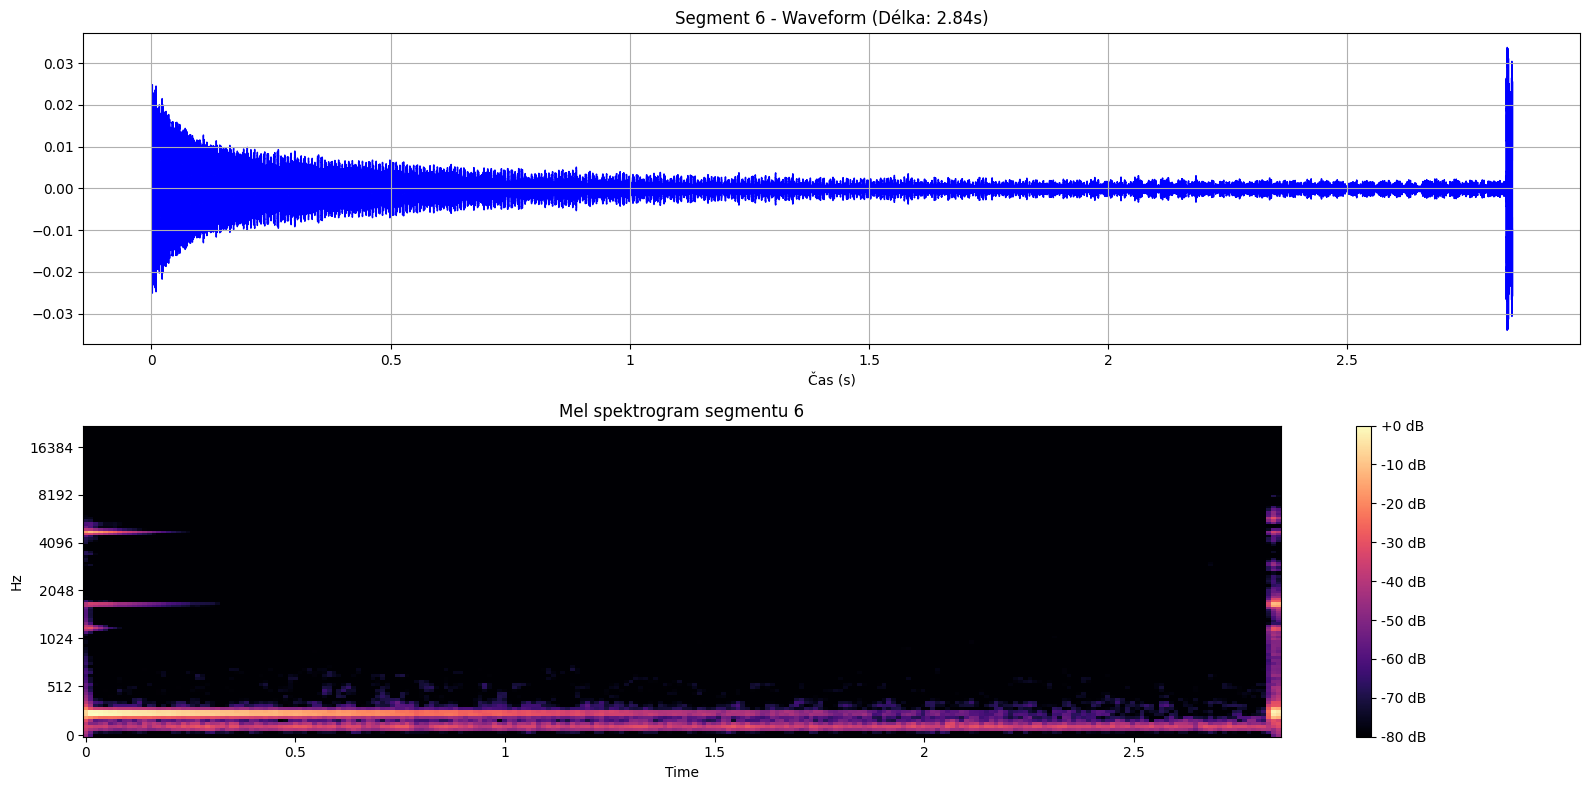

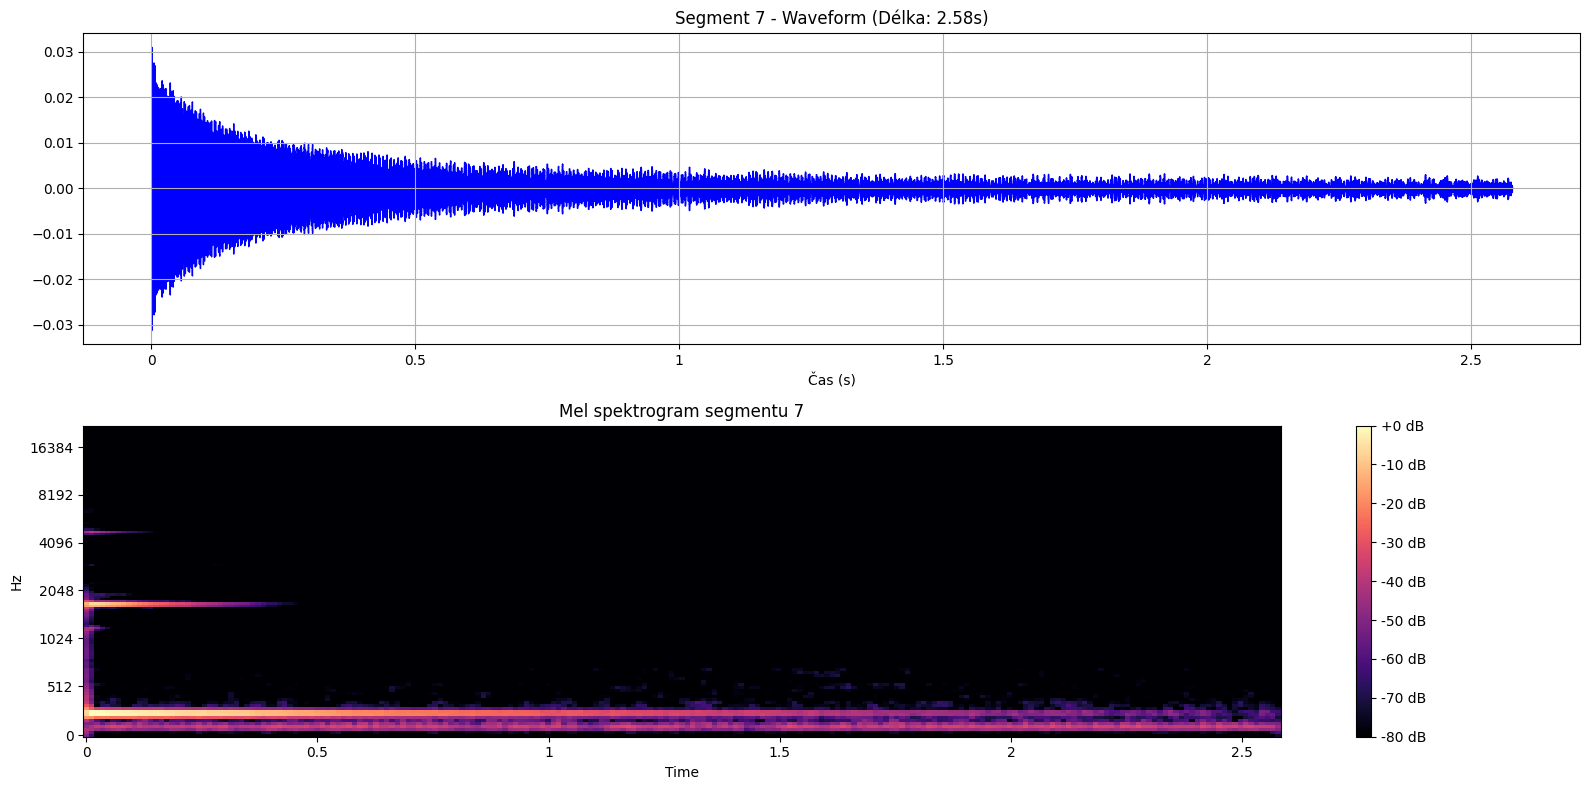

In [13]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

# Načtení audia
audio_path = "output.wav"
y, sr = librosa.load(audio_path, sr=None)

# Detekce onsetů
onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time', delta=0.2, wait=10)
onsets = np.append(onsets, len(y)/sr)  # Přidáme konec souboru

# Vytvoření spektrogramu pro celý soubor
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("Celkový spektrogram s detekovanými onsety")
plt.vlines(onsets, 0, sr/2, color='cyan', linestyle='--', linewidth=2, alpha=0.9)
plt.tight_layout()
plt.show()

# Detailní analýza každého segmentu
for i in range(len(onsets)-1):
    start = onsets[i]
    end = onsets[i+1]
    segment = y[int(start*sr):int(end*sr)]
    
    # Vytvoření subplotů pro každý segment
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))
    
    # Waveform
    librosa.display.waveshow(segment, sr=sr, ax=ax[0], color='blue')
    ax[0].set_title(f"Segment {i+1} - Waveform (Délka: {end-start:.2f}s)")
    ax[0].set_xlabel("Čas (s)")
    ax[0].grid(True)
    
    # Mel spektrogram
    S = librosa.feature.melspectrogram(y=segment, sr=sr)
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', 
                              ax=ax[1], cmap='magma')
    fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
    ax[1].set_title(f"Mel spektrogram segmentu {i+1}")
    
    plt.tight_layout()
    plt.show()
    
    # Uložení segmentu
    sf.write(f"segment_{i+1}.wav", segment, sr)

C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


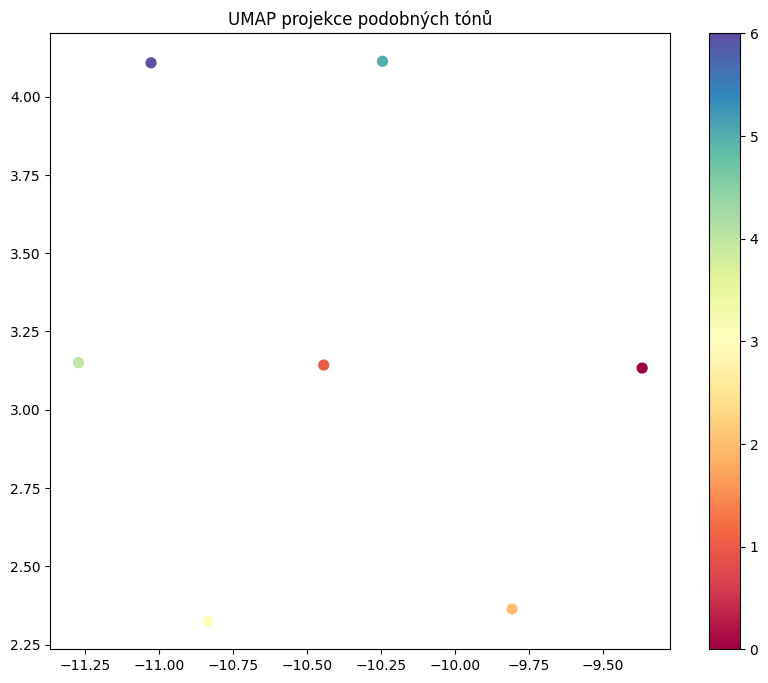

In [16]:
import numpy as np
import librosa
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN  # Pro automatické seskupování podobných

def extract_features(segment, sr):
    # MFCC (13 koeficientů)
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
    # Průměr přes čas
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

# Načtení všech segmentů a extrakce příznaků
segments = []
for i in range(len(onsets)-1):
    start = int(onsets[i] * sr)
    end = int(onsets[i+1] * sr)
    segment = y[start:end]
    features = extract_features(segment, sr)
    segments.append(features)

features_matrix = np.array(segments)

similarity_matrix = cosine_similarity(features_matrix)

# DBSCAN pro detekci shluků (epsilon nastavte podle potřeby)
clustering = DBSCAN(eps=0.3, min_samples=1).fit(features_matrix)
labels = clustering.labels_

# Uložení pouze jednoho zástupce z každého shluku
unique_segments = {}
for i, label in enumerate(labels):
    if label not in unique_segments:
        unique_segments[label] = i

# Uložení unikátních segmentů
for label, idx in unique_segments.items():
    start = int(onsets[idx] * sr)
    end = int(onsets[idx+1] * sr)
    segment = y[start:end]
    sf.write(f"unique_ton_{label}.wav", segment, sr)

import umap.umap_ as umap  # Korektní import pro verzi umap-learn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Normalizace příznaků
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_matrix)

# Redukce na 2D pomocí UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
projection = reducer.fit_transform(features_scaled)

# Vizualizace
plt.figure(figsize=(10, 8))
plt.scatter(projection[:, 0], projection[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar()
plt.title("UMAP projekce podobných tónů")
plt.show()


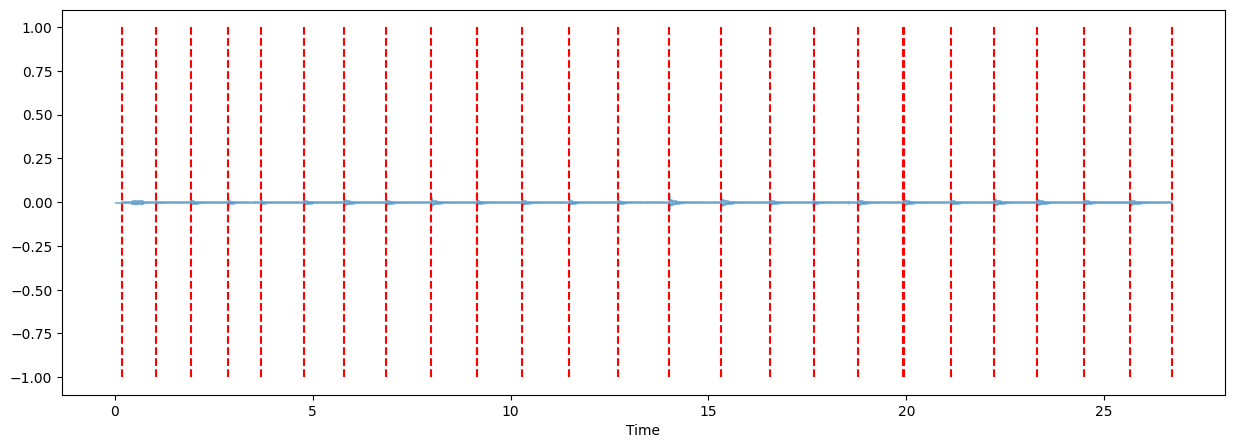

C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=513
  warnings.warn(
C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Klastr s nejvíce segmenty: 0, počet: 24
Segmenty z klastru 0 byly uloženy do složky common_segments_d2.


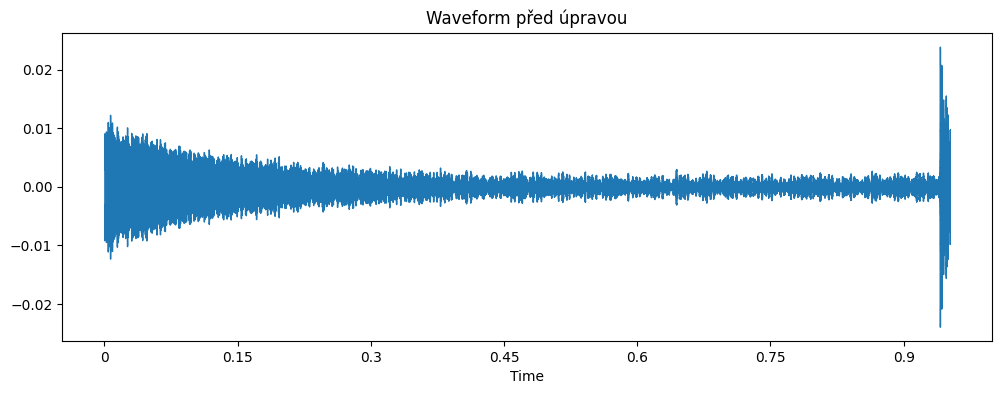

In [43]:
import librosa
import numpy as np
import soundfile as sf
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import librosa.display

# ===============================
# 1. Načtení audio souboru a segmentace
# ===============================
audio_path = "d2_output.wav"
y, sr = librosa.load(audio_path, sr=None)

# Detekce onsetů (začátků tónů)
onsets = librosa.onset.onset_detect(
    y=y, 
    sr=sr, 
    units='time',
    hop_length=512,
    pre_max=3,
    post_max=3,
    pre_avg=3,
    post_avg=3,
    delta=0.3,
    wait=0
)

# Přidáme konec souboru jako poslední onset
onsets = np.append(onsets, len(y)/sr)

# Uložení jednotlivých segmentů do seznamu a souborů
segments = []
for i in range(len(onsets)-1):
    start_sample = int(onsets[i] * sr)
    end_sample = int(onsets[i+1] * sr)
    segment = y[start_sample:end_sample]
    segments.append(segment)
    sf.write(f"ton_{i+1}.wav", segment, sr)

# Pro vizualizaci původního audio se zobrazením onsetů:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.vlines(onsets, -1, 1, color='r', linestyle='--')
plt.show()

# ===============================
# 2. Extrakce příznaků z jednotlivých segmentů
# ===============================
# Jako příklad použijeme 13 MFCC koeficientů, které zprůměrujeme přes čas
features = []
for seg in segments:
    # Pokud má segment velmi krátkou délku, může být výpočet MFCC ovlivněn; lze přidat ochranu
    mfcc = librosa.feature.mfcc(y=seg, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)  # průměr přes čas
    features.append(mfcc_mean)
features = np.array(features)

# ===============================
# 3. Shlukování (clustering) segmentů
# ===============================
# Zvolíme počet klastrů – pokud očekáváte, že jen jeden tón se opakuje často,
# můžete vyzkoušet např. k=2 nebo k=3 a poté vybrat klastr s největším počtem segmentů.
k = 2  # můžete experimentovat s touto hodnotou
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(features)

# Zjistíme, který klastr má nejvíce členů (předpokládáme, že to je ten opakující se tón)
unique, counts = np.unique(labels, return_counts=True)
max_cluster = unique[np.argmax(counts)]
print(f"Klastr s nejvíce segmenty: {max_cluster}, počet: {np.max(counts)}")

# ===============================
# 4. Uložení segmentů, které patří do největšího klastru
# ===============================
output_dir = "common_segments_d2"
os.makedirs(output_dir, exist_ok=True)

for i, seg in enumerate(segments):
    if labels[i] == max_cluster:
        sf.write(os.path.join(output_dir, f"common_{i+1}.wav"), seg, sr)

print(f"Segmenty z klastru {max_cluster} byly uloženy do složky {output_dir}.")

# PAK SMAZAT TESTING
import librosa.display

data, sr = librosa.load("common_segments_d2/common_3.wav", sr=None)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr)
plt.title("Waveform před úpravou")
plt.show()


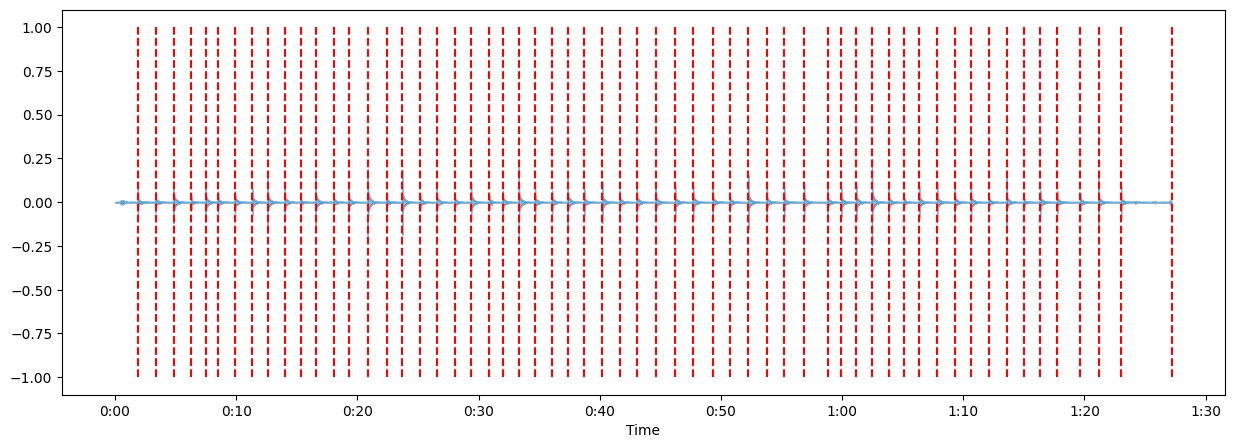

C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Klastr s nejvíce segmenty: 1, počet: 43
Segmenty z klastru 1 byly uloženy do složky data/e6.


In [21]:
# SUPER FUNGUJE!!!!

import librosa
import numpy as np
import soundfile as sf
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import librosa.display

# ===============================
# 1. Načtení audio souboru a segmentace
# ===============================
audio_path = "E6.wav"
y, sr = librosa.load(audio_path, sr=None)

# Detekce onsetů
onsets = librosa.onset.onset_detect(
    y=y, 
    sr=sr, 
    units='time',
    hop_length=512,
    pre_max=3,
    post_max=3,
    pre_avg=3,
    post_avg=3,
    delta=0.3,
    wait=0
)

onsets = np.append(onsets, len(y)/sr)  # Přidáme konec souboru

segments = []
for i in range(len(onsets)-1):
    start_time = onsets[i]
    end_time = onsets[i+1] - 0.05  # Odečteme 50 ms od konce
    
    # Ošetření, aby end_time nebyl dříve než start_time
    if end_time <= start_time:
        end_time = start_time + 0.001  # Minimální délka 1 ms (aby nevznikly prázdné segmenty)
    
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    segment = y[start_sample:end_sample]
    segments.append(segment)
    sf.write(f"ton_{i+1}.wav", segment, sr)

# Pro vizualizaci původního audio se zobrazením onsetů:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.vlines(onsets, -1, 1, color='r', linestyle='--')
plt.show()

# ===============================
# 2. Extrakce příznaků z jednotlivých segmentů
# ===============================
# Jako příklad použijeme 13 MFCC koeficientů, které zprůměrujeme přes čas
features = []
for seg in segments:
    # Pokud má segment velmi krátkou délku, může být výpočet MFCC ovlivněn; lze přidat ochranu
    mfcc = librosa.feature.mfcc(y=seg, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)  # průměr přes čas
    features.append(mfcc_mean)
features = np.array(features)

# ===============================
# 3. Shlukování (clustering) segmentů
# ===============================
# Zvolíme počet klastrů – pokud očekáváte, že jen jeden tón se opakuje často,
# můžete vyzkoušet např. k=2 nebo k=3 a poté vybrat klastr s největším počtem segmentů.
k = 2  # můžete experimentovat s touto hodnotou
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(features)

# Zjistíme, který klastr má nejvíce členů (předpokládáme, že to je ten opakující se tón)
unique, counts = np.unique(labels, return_counts=True)
max_cluster = unique[np.argmax(counts)]
print(f"Klastr s nejvíce segmenty: {max_cluster}, počet: {np.max(counts)}")

# ===============================
# 4. Uložení segmentů, které patří do největšího klastru
# ===============================
output_dir = "data/e6"
os.makedirs(output_dir, exist_ok=True)

for i, seg in enumerate(segments):
    if labels[i] == max_cluster:
        sf.write(os.path.join(output_dir, f"14t_{i+1}.wav"), seg, sr)

print(f"Segmenty z klastru {max_cluster} byly uloženy do složky {output_dir}.")

# PAK SMAZAT TESTING
#import librosa.display

#data, sr = librosa.load("clear/c4/14t_8.wav", sr=None)
#plt.figure(figsize=(12, 4))
#librosa.display.waveshow(data, sr=sr)
#plt.title("Waveform před úpravou")
#plt.show()


In [22]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

# Načtení WAV souborů
sample_rate1, data1 = wavfile.read('common_segments_d2/common_21.wav')
sample_rate2, data2 = wavfile.read('common_segments_g5/common_3.wav')

# Převod na mono (pokud je stereo)
if data1.ndim > 1:
    data1 = data1[:, 0]
if data2.ndim > 1:
    data2 = data2[:, 0]

# Normalizace na rozsah [-1, 1] (pro int typy)
data1 = data1.astype(float)
data2 = data2.astype(float)
if data1.dtype == np.int16:
    data1 /= 32768.0
if data2.dtype == np.int16:
    data2 /= 32768.0

# Vytvoření spektrogramů
plt.figure(figsize=(12, 8))

# První spektrogram
plt.subplot(2, 1, 1)
plt.specgram(data1, Fs=sample_rate1, scale='dB', cmap='viridis')
plt.title('Spektrogram souboru 1')
plt.xlabel('Čas [s]')
plt.ylabel('Frekvence [Hz]')
plt.colorbar(label='Intenzita [dB]')

# Druhý spektrogram
plt.subplot(2, 1, 2)
plt.specgram(data2, Fs=sample_rate2, scale='dB', cmap='viridis')
plt.title('Spektrogram souboru 2')
plt.xlabel('Čas [s]')
plt.ylabel('Frekvence [Hz]')
plt.colorbar(label='Intenzita [dB]')

plt.tight_layout()
plt.show()

TypeError: fix_length() takes 1 positional argument but 2 were given

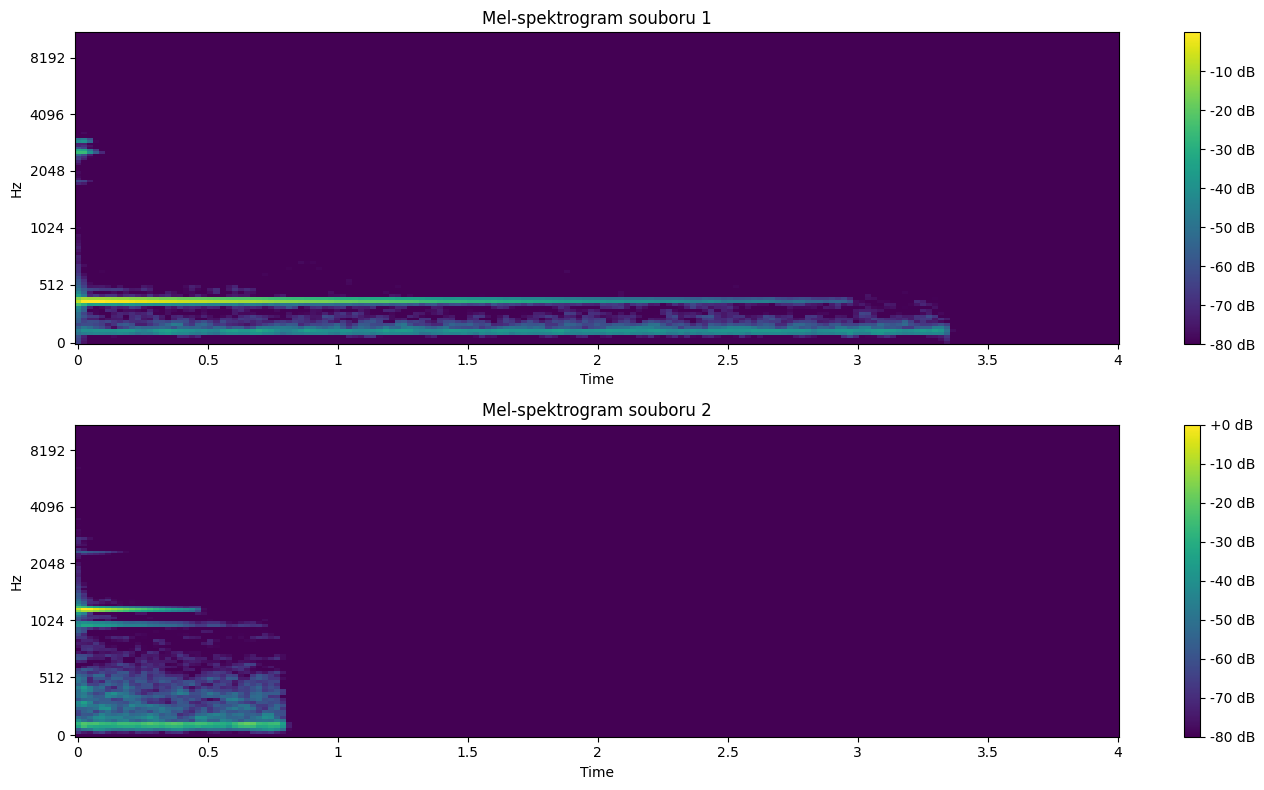

In [57]:
# SUPER FUNGUJE!!!

import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

def load_and_preprocess(file_path, target_sr=22050, target_duration=4):
    # Načtení s převzorkováním na target_sr
    data, sr = librosa.load(file_path, sr=target_sr)
    
    # Výpočet cílové délky ve vzorcích
    target_length = int(target_duration * target_sr)
    
    # Oříznutí nebo doplnění nulami (s explicitním `size`)
    data_processed = librosa.util.fix_length(data, size=target_length)
    
    return data_processed, sr

# Parametry pro Mel-spektrogram
n_fft = 2048          # Velikost FFT okna
hop_length = 512       # Posun mezi okny
n_mels = 128           # Počet Melových pásem

# Načtení WAV souborů
#data1, sr1 = load_and_preprocess('common_segments_d2/common_2.wav')  # `sr=None` zachová původní vzorkovací frekvenci
data2, sr2 = load_and_preprocess('common_segments_d2/common_4.wav')
data1, sr1 = load_and_preprocess('common_segments_g5/common_2.wav')
#data2, sr2 = load_and_preprocess('common_segments_g5/common_4.wav')

# Výpočet Mel-spektrogramů
mel_spect1 = librosa.feature.melspectrogram(y=data1, sr=sr1, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_spect1_db = librosa.amplitude_to_db(mel_spect1, ref=np.max)  # Převod na decibely

mel_spect2 = librosa.feature.melspectrogram(y=data2, sr=sr2, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_spect2_db = librosa.amplitude_to_db(mel_spect2, ref=np.max)

# Vykreslení
plt.figure(figsize=(14, 8))

# První Mel-spektrogram
plt.subplot(2, 1, 1)
librosa.display.specshow(
    mel_spect1_db, 
    sr=sr1, 
    hop_length=hop_length, 
    x_axis='time', 
    y_axis='mel', 
    cmap='viridis'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spektrogram souboru 1')

# Druhý Mel-spektrogram
plt.subplot(2, 1, 2)
librosa.display.specshow(
    mel_spect2_db, 
    sr=sr2, 
    hop_length=hop_length, 
    x_axis='time', 
    y_axis='mel', 
    cmap='viridis'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spektrogram souboru 2')

plt.tight_layout()
plt.show()

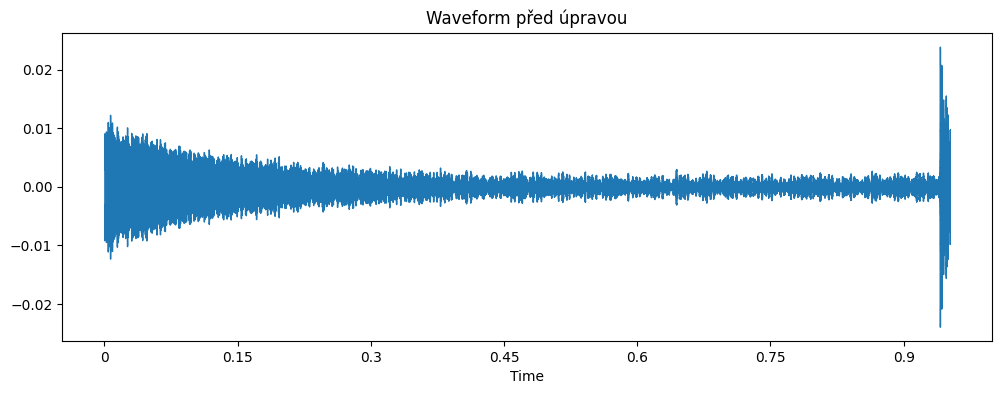

In [40]:
import librosa.display

data, sr = librosa.load("common_segments_d2/common_3.wav", sr=None)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr)
plt.title("Waveform před úpravou")
plt.show()

In [4]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Parametry
SAMPLE_RATE = 22050  # Librosa default
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = (128, 128)  # Výstupní velikost spektrogramu

def load_wav_files(folder, target_tone_label=1):
    X, y = [], []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            filepath = os.path.join(folder, file)
            signal, sr = librosa.load(filepath, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Přidání kanálu
            mel_spec_db = tf.image.resize(mel_spec_db, IMG_SIZE).numpy()  # Změna velikosti
            X.append(mel_spec_db)
            y.append(target_tone_label)  # Označení tónu (např. 1 pro cílový tón, 0 pro ostatní)
    return np.array(X), np.array(y)

# Cesta ke složce s cílovým tónem
pos_folder = "clear/c4"  # Složka s cílovým tónem

# Načtení datasetu
X_pos, y_pos = load_wav_files(pos_folder, target_tone_label=1)

# Generování negativních příkladů (šum nebo náhodné hodnoty)
X_neg = np.random.normal(size=(len(X_pos), IMG_SIZE[0], IMG_SIZE[1], 1))
y_neg = np.zeros(len(X_pos))

# Spojení dat a vytvoření trénovací sady
X = np.vstack((X_pos, X_neg))
y = np.hstack((y_pos, y_neg))

# Rozdělení datasetu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vytvoření modelu CNN
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binární klasifikace
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Inicializace modelu
model = create_model()

# Trénování modelu
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# Uložení modelu
model.save("tone_recognition_model.h5")

print("Trénování dokončeno. Model uložen jako 'tone_recognition_model.h5'")






Epoch 1/20


3/3 [==============================] - 3s 262ms/step - loss: 18.3059 - accuracy: 0.6974 - val_loss: 0.0547 - val_accuracy: 1.0000
Epoch 2/20
3/3 [==============================] - 0s 115ms/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 3.1551e-08 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 0s 117ms/step - loss: 0.3918 - accuracy: 0.7368 - val_loss: 3.8061e-11 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 0s 113ms/step - loss: 4.1635e-11 - accuracy: 1.0000 - val_loss: 2.6225e-11 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 0s 117ms/step - loss: 2.3241e-11 - accuracy: 1.0000 - val_loss: 9.2819e-12 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 0s 113ms/step - loss: 8.2427e-12 - accuracy: 1.0000 - val_loss: 2.9381e-12 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 0s 114ms/step - loss: 2.4981e-12 - accuracy: 1.0000 - val_loss: 9.9948e

C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Parametry
SAMPLE_RATE = 22050  # Librosa default
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = (128, 128)  # Výstupní velikost spektrogramu

def load_wav_files(folder, label):
    X, y = [], []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            filepath = os.path.join(folder, file)
            signal, sr = librosa.load(filepath, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Přidání kanálu
            mel_spec_db = tf.image.resize(mel_spec_db, IMG_SIZE).numpy()  # Změna velikosti
            X.append(mel_spec_db)
            y.append(label)  # Označení tónu (0 = C4, 1 = D4, 2 = E4)
    return np.array(X), np.array(y)

# Cesty ke složkám s tóny
tone_folders = {"C4": "clear/c4", "D4": "clear/d4", "E4": "clear/e4"}
labels = {"C4": 0, "D4": 1, "E4": 2}

# Načtení datasetu
X, y = [], []
for tone, folder in tone_folders.items():
    X_tone, y_tone = load_wav_files(folder, labels[tone])
    X.append(X_tone)
    y.append(y_tone)

X = np.vstack(X)
y = np.hstack(y)

# Rozdělení datasetu na trénovací, validační a testovací sadu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vytvoření modelu CNN
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # Multiklase klasifikace
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Inicializace modelu
model = create_model()

# Trénování modelu
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

# Uložení modelu
model.save("tone_recognition_model.h5")

print("Trénování dokončeno. Model uložen jako 'tone_recognition_model.h5'")


Epoch 1/20
4/4 [==============================] - 2s 176ms/step - loss: 57.3654 - accuracy: 0.3402 - val_loss: 11.4408 - val_accuracy: 0.2812
Epoch 2/20
4/4 [==============================] - 0s 106ms/step - loss: 6.0064 - accuracy: 0.3196 - val_loss: 2.7522 - val_accuracy: 0.2812
Epoch 3/20
4/4 [==============================] - 0s 105ms/step - loss: 3.0172 - accuracy: 0.4227 - val_loss: 1.8996 - val_accuracy: 0.3438
Epoch 4/20
4/4 [==============================] - 0s 103ms/step - loss: 1.3236 - accuracy: 0.3196 - val_loss: 1.0551 - val_accuracy: 0.2812
Epoch 5/20
4/4 [==============================] - 0s 102ms/step - loss: 1.0567 - accuracy: 0.5155 - val_loss: 0.9924 - val_accuracy: 0.6250
Epoch 6/20
4/4 [==============================] - 0s 104ms/step - loss: 1.0057 - accuracy: 0.6289 - val_loss: 0.9915 - val_accuracy: 0.6562
Epoch 7/20
4/4 [==============================] - 0s 100ms/step - loss: 0.9813 - accuracy: 0.6598 - val_loss: 0.9164 - val_accuracy: 0.6562
Epoch 8/20
4/4 [==

In [11]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Parametry
SAMPLE_RATE = 22050  # Librosa default
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = (128, 128)  # Výstupní velikost spektrogramu

def load_wav_files(folder, label):
    X, y = [], []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            filepath = os.path.join(folder, file)
            signal, sr = librosa.load(filepath, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Přidání kanálu
            mel_spec_db = tf.image.resize(mel_spec_db, IMG_SIZE).numpy()  # Změna velikosti
            X.append(mel_spec_db)
            y.append(label)  # Označení tónu (0 = C4, 1 = D4, 2 = E4)
    return np.array(X), np.array(y)

# Cesty ke složkám s tóny
tone_folders = {"C4": "data/c4", "D4": "data/d4", "E4": "data/e4", "F4": "data/f4", "G4": "data/g4", "A4": "data/a4", "B4": "data/b4"}
labels = {"C4": 0, "D4": 1, "E4": 2, "F4": 3, "G4": 4, "A4": 5, "B4": 6,}

# Načtení datasetu
X, y = [], []
for tone, folder in tone_folders.items():
    X_tone, y_tone = load_wav_files(folder, labels[tone])
    X.append(X_tone)
    y.append(y_tone)

X = np.vstack(X)
y = np.hstack(y)

# Odebrání několika vzorků pro dodatečné testování
X_train, X_extra, y_train, y_extra = train_test_split(X, y, test_size=0.05, random_state=42)

# Rozdělení datasetu na trénovací (60 %), validační (20 %) a testovací (20 %) sadu
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 0.5 * 0.4 = 0.2

# Vytvoření modelu CNN
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')  # Multiklase klasifikace
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Inicializace modelu
model = create_model()

# Trénování modelu
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

# Uložení modelu
model.save("tone_recognition_model.h5")

# Testování na extra vzorcích
predictions = model.predict(X_extra)
predicted_labels = np.argmax(predictions, axis=1)

# Výpis výsledků
for i in range(len(X_extra)):
    print(f"Skutečná třída: {y_extra[i]}, Predikovaná třída: {predicted_labels[i]}")

print("Trénování dokončeno. Model uložen jako 'tone_recognition_model.h5'")


Epoch 1/20
7/7 [==============================] - 3s 205ms/step - loss: 7.6607 - accuracy: 0.1553 - val_loss: 1.9667 - val_accuracy: 0.1096
Epoch 2/20
7/7 [==============================] - 1s 142ms/step - loss: 1.7137 - accuracy: 0.4018 - val_loss: 1.4932 - val_accuracy: 0.3836
Epoch 3/20
7/7 [==============================] - 1s 144ms/step - loss: 0.7829 - accuracy: 0.8174 - val_loss: 0.2481 - val_accuracy: 0.9589
Epoch 4/20
7/7 [==============================] - 1s 140ms/step - loss: 0.0966 - accuracy: 0.9863 - val_loss: 0.1890 - val_accuracy: 0.9589
Epoch 5/20
7/7 [==============================] - 1s 138ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.2260 - val_accuracy: 0.9726
Epoch 6/20
7/7 [==============================] - 1s 145ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.3050 - val_accuracy: 0.9726
Epoch 7/20
7/7 [==============================] - 1s 144ms/step - loss: 1.7726e-04 - accuracy: 1.0000 - val_loss: 0.3859 - val_accuracy: 0.9726
Epoch 8/20
7/7 [

In [19]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Parametry
SAMPLE_RATE = 22050  # Librosa default
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = (128, 128)  # Výstupní velikost spektrogramu

def load_wav_files(folder, label):
    X, y = [], []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            filepath = os.path.join(folder, file)
            signal, sr = librosa.load(filepath, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Přidání kanálu
            mel_spec_db = tf.image.resize(mel_spec_db, IMG_SIZE).numpy()  # Změna velikosti
            X.append(mel_spec_db)
            y.append(label)  # Označení tónu (0 = C4, 1 = D4, 2 = E4)
    return np.array(X), np.array(y)

# Cesty ke složkám s tóny
tone_folders = {"C4": "clear/c4", "D4": "clear/d4", "E4": "clear/e4"}
labels = {"C4": 0, "D4": 1, "E4": 2}

# Načtení datasetu
X, y = [], []
for tone, folder in tone_folders.items():
    X_tone, y_tone = load_wav_files(folder, labels[tone])
    X.append(X_tone)
    y.append(y_tone)

X = np.vstack(X)
y = np.hstack(y)

# Odebrání několika vzorků pro dodatečné testování
X_train, X_extra, y_train, y_extra = train_test_split(X, y, test_size=0.05, random_state=42)

# Rozdělení datasetu na trénovací (60 %), validační (20 %) a testovací (20 %) sadu
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 0.5 * 0.4 = 0.2

# Vytvoření modelu CNN
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='sigmoid')  # Multiklase klasifikace
    ])
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # Multi-label loss
                  metrics=['accuracy'])
    return model

# Inicializace modelu
model = create_model()

# Trénování modelu
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

# Uložení modelu
model.save("tone_recognition_model_sigmoid.h5")

# Testování na extra vzorcích
predictions = model.predict(X_extra)
predicted_labels = np.argmax(predictions, axis=1)

# Výpis výsledků
for i in range(len(X_extra)):
    print(f"Skutečná třída: {y_extra[i]}, Predikovaná třída: {predicted_labels[i]}")

print("Trénování dokončeno. Model uložen jako 'tone_recognition_model.h5'")


Epoch 1/20


ValueError: in user code:

    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 3) vs (None, 1)).


In [22]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Parametry (zůstávají stejné)
SAMPLE_RATE = 22050
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

def load_wav_files(folder, label):
    X, y = [], []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            filepath = os.path.join(folder, file)
            signal, sr = librosa.load(filepath, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, 
                                                     hop_length=HOP_LENGTH, n_mels=N_MELS)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
            mel_spec_db = tf.image.resize(mel_spec_db, IMG_SIZE).numpy()
            X.append(mel_spec_db)
            y.append(label)
    return np.array(X), np.array(y)

# Cesty ke složkám
tone_folders = {"C4": "data/c4", "D4": "data/d4", "E4": "data/e4", "F4": "data/f4", "G4": "data/g4", "A4": "data/a4", "B4": "data/b4", "C5": "data/c5", "D5": "data/d5", "E5": "data/e5", "F5": "data/f5", "G5": "data/g5", "A5": "data/a5", "B5": "data/b5", "C6": "data/c6", "D6": "data/d6", "E6": "data/e6"}
labels = {"C4": 0, "D4": 1, "E4": 2, "F4": 3, "G4": 4, "A4": 5, "B4": 6, "C5": 7, "D5": 8, "E5": 9, "F5": 10, "G5": 11, "A5": 12, "B5": 13, "C6": 14, "D6": 15, "E6": 16}

# Načtení datasetu
X, y = [], []
for tone, folder in tone_folders.items():
    X_tone, y_tone = load_wav_files(folder, labels[tone])
    X.append(X_tone)
    y.append(y_tone)

X = np.vstack(X)
y = np.hstack(y)

# Konverze integer labels na one-hot encoding
y = to_categorical(y, num_classes=17)  # Důležitá změna!

# Rozdělení datasetu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vytvoření modelu pro multi-label klasifikaci
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(17, activation='sigmoid')  # Sigmoid pro multi-label
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # Správná loss pro multi-label
                  metrics=['accuracy'])
    return model

model = create_model()
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

# Uložení modelu
model.save("tone_recognition_multi_label.h5")

# Testování s prahovou hodnotou
def multi_label_predict(predictions, threshold=0.5):
    return (predictions > threshold).astype(int)

test_predictions = model.predict(X_test)
binary_predictions = multi_label_predict(test_predictions)

# Výpis výsledků
for i in range(5):  # Ukázka prvních 5 vzorků
    print(f"Skutečné: {y_test[i]}, Predikované: {binary_predictions[i]}")

C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=309
  warnings.warn(
C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1956
  warnings.warn(





Epoch 1/20


21/21 [==============================] - 6s 148ms/step - loss: 1.1528 - accuracy: 0.0588 - val_loss: 0.2250 - val_accuracy: 0.0679
Epoch 2/20
21/21 [==============================] - 3s 127ms/step - loss: 0.2161 - accuracy: 0.1931 - val_loss: 0.1961 - val_accuracy: 0.3891
Epoch 3/20
21/21 [==============================] - 3s 129ms/step - loss: 0.1438 - accuracy: 0.5988 - val_loss: 0.0812 - val_accuracy: 0.8190
Epoch 4/20
21/21 [==============================] - 3s 130ms/step - loss: 0.0448 - accuracy: 0.9502 - val_loss: 0.0204 - val_accuracy: 0.9774
Epoch 5/20
21/21 [==============================] - 3s 128ms/step - loss: 0.0092 - accuracy: 0.9925 - val_loss: 0.0084 - val_accuracy: 0.9910
Epoch 6/20
21/21 [==============================] - 3s 133ms/step - loss: 0.0040 - accuracy: 0.9955 - val_loss: 0.0051 - val_accuracy: 0.9955
Epoch 7/20
21/21 [==============================] - 3s 129ms/step - loss: 0.0023 - accuracy: 0.9985 - val_loss: 0.0054 - val_accuracy: 0.9955
E

C:\Users\Dave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 30ms/step
Skutečné: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Predikované: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Skutečné: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], Predikované: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Skutečné: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], Predikované: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Skutečné: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Predikované: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
Skutečné: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], Predikované: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
